In [2]:
import pandas as pd
import numpy as np

import importlib
import sys
sys.path.append('D:\\...') # ścieżka do folderu, w którym znajduje się podfolder 'cl_explainable_stylo'
from cl_explainable_stylo import base

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_core_web_trf' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
importlib.reload(base)
exp = base.explain_style('exp_stylo_july.json',manual = True)
# exp.texts_load()

Initialisation metadata loaded from exp_stylo_july.json.
Available text labels ['filename', 'class', 'term'].
Predefined text classes ['wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', 'wiki', '

In [8]:
exp.docs_load('JKA/docs.spacy')

Provided model name for Spacy: 'en_core_web_lg'.
Labels ['filename', 'class', 'term'] will be now accessible in documents via 'document._.label'.
Loaded 17073 documents.


In [9]:
# Właściwie to przy ustawieniu "none", nic tam się nie dzieje,
# ale 'sample_length' jest potem częścią folderu z wynikami i chyba gdzieś to jest potrzebne w strukturze danych w klasie
exp.subsample_scheme = {'sample_type': 'none', 'sample_length': 10}
exp.texts_subsample()

No text subsampling with current setting: 'sample_type = 'none'.


In [4]:
from cl_explainable_stylo import text_classify
importlib.reload(text_classify)

exp.cv_scheme = {'n_repeats':1,'cv_method':'GroupKFold','n_splits': 10,'val_fraction':0., 
                 'scoring':{'acc':text_classify.dic_to_score['acc'],'f1':text_classify.dic_to_score['f1']}}

exp.cv_scheme

{'n_repeats': 1,
 'cv_method': 'GroupKFold',
 'n_splits': 10,
 'val_fraction': 0.0,
 'scoring': {'acc': {'func': <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>},
  'f1': {'func': <function sklearn.metrics._classification.fbeta_score(y_true, y_pred, *, beta, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
   'params': {'beta': 1, 'average': 'macro'}}}}

In [6]:
# exp.feature_scheme = {'features':[13,23,31,51],
#                        'max_features':1000,
#                        'n_grams_word':(1,3),
#                        'n_grams_pos':(1,3),
#                        'n_grams_dep':(1,3),
#                        'n_grams_morph':(1,1),
#                        'min_cull_word':0., # ignore terms that have a document frequency strictly lower than the given threshold
#                        'max_cull_word':1., # ignore terms that have a document frequency strictly higher than the given threshold
#                        'min_cull_d2':0.,
#                        'max_cull_d2':1.,
#                        'remove_duplicates':False}
# exp.extract_features(save_to_file=True)
exp.features_load('JKA/features_13,23,31,51.csv') # załadowanie cech moich. Można je też zrobić od zera tak, jak powyżej wykomentowane
# exp.features_load('JKA/features.csv') # załadowanie cech ze stylometriksa

Features loaded from 'JKA/features_13,23,31,51.csv' to '.feature_dataframe' attribute.


In [5]:
# exp.classifier_scheme['objective'] = 'binary'
# exp.classifier_scheme['metric'] = ['binary']
# exp.classifier_scheme['num_class'] = 1
# exp.save_params_classifier()
exp.load_params_classifier('JKA/binary_classifier_scheme.json')
exp.classifier_scheme

'Classifier parameters' loaded from 'JKA/multiclass_classifier_scheme.json'.


{'objective': 'multiclass',
 'learning_rate': 0.5,
 'metric': ['multiclass', 'multi_error'],
 'nthread': 12,
 'boosting': 'dart',
 'num_leaves': 5,
 'num_iterations': 100,
 'max_depth': 5,
 'bagging_freq': 3,
 'bagging_fraction': 0.8,
 'verbose': -1,
 'num_class': 7}

In [9]:
# Zapisanie pełnych danych do zmiennych,
# bo zaraz będziemy z nich wybierać tylko fragmenty do 
# klasyfikacji binarnej poszczególnych modeli

docs = exp.docs
meta_df = pd.DataFrame(exp.metadata['files'])
feature_df = exp.feature_dataframe
classes = np.unique(meta_df['class'])
classes = classes[[6,1,2,3,4,5,0]]
classes

array(['wiki', 'gpt3', 'gpt4', 'llama2', 'llama3', 'orca', 'falcon'],
      dtype=object)

In [10]:
all_scores = pd.DataFrame()
for i in range(len(classes)):
    for j in range(i+1,len(classes)):
# i=6
# j=6
        exp.docs = [docs[index] for index in np.flatnonzero((meta_df['class'] == classes[i]) | (meta_df['class'] == classes[j]))]
        exp.metadata['files'] = meta_df[(meta_df['class'] == classes[i]) | (meta_df['class'] == classes[j])].to_dict(orient = 'list')
        exp.feature_dataframe = feature_df[(meta_df['class'] == classes[i]) | (meta_df['class'] == classes[j])]
        exp.feature_dataframe = exp.feature_dataframe.reset_index(drop = True)
        exp.texts_subsample()
        exp.cv_scheme['n_splits'] = 10
        exp.classify(group_category='term',save_to_file=True)
        exp.scores.df_all["pair"] = classes[i]+' '+classes[j]
        all_scores = all_scores.append(exp.scores.df_all)

No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


  0%|          | 0/1 [00:00<?, ?it/s]

'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488


D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_22.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_22.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_23.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_23.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_23.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_23.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_24.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_24.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.94 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.93 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_24.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_24.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_25.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_25.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_25.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_25.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_26.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_26.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.96 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.96 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_26.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_26.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_27.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_27.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.94 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.92 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_27.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_27.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_28.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_28.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.90 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.90 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_28.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_28.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_29.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_29.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.93 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.92 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_29.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_29.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_30.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_30.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.91 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.91 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_30.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_30.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_31.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_31.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_31.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_31.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_32.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_32.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_32.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_32.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_33.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_33.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.97 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.97 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_33.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_33.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_34.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_34.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.93 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.93 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_34.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_34.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_35.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_35.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.98 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.98 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_35.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_35.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_36.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_36.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_36.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_36.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_37.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_37.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.86 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.81 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_37.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_37.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_38.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_38.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.98 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.98 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_38.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_38.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_39.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_39.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488


D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.98 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.98 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_39.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_39.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_40.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_40.pkl'. It can be reloaded with '.load_params_cv(filename)'.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


  0%|          | 0/1 [00:00<?, ?it/s]

'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488


D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	1.00 	 Baseline value:  0.50
F1 [0-1, higher better]: 		1.00 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_40.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_40.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_41.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_41.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488


D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_41.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_41.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_42.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_42.pkl'. It can be reloaded with '.load_params_cv(filename)'.
No text subsampling with current setting: 'sample_type = 'none'.
Proceeding with 2 classes.
Proceeding with 2439 classes.
Proceeding with GroupKFold cross-validation.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


  0%|          | 0/1 [00:00<?, ?it/s]

D:\ProgramData\Anaconda3\envs\clarin\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, Test:488
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:4390, Val:0, T

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.88 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.88 	 Baseline value:  0.33
Scores saved as explain_watermarking_july\subsamples_none_10\scores_class-class_group-term_42.pkl.
Classifiers saved as explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term_42.pkl.
Classifier parameters saved as 'explain_watermarking_july\subsamples_none_10\config_classifier_scheme_43.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_watermarking_july\subsamples_none_10\config_cv_scheme_43.pkl'. It can be reloaded with '.load_params_cv(filename)'.


C:\Users\JOchab\AppData\Local\Temp\ipykernel_36184\3970655721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(exp.scores.df_all)


In [12]:
# Wypisanie macierzy trójkątnej z wynikami 

arr = np.zeros((len(classes),len(classes)))
for i in range(len(classes)):
    for j in range(i+1,len(classes)):
        arr[i,j] = all_scores[all_scores.pair == classes[i]+' '+classes[j]].acc.mean()
# print(arr)

# Function to round each element to two significant digits
def format_to_significant_digits(arr, significant_digits):
    formatted_array = []
    for row in arr:
        formatted_row = []
        for num in row:
            if num != 0:
                # Determine the power of 10 of the number
                power = np.floor(np.log10(abs(num)))
                # Calculate the number of decimal places to retain
                decimals = significant_digits - int(power) - 1
                # Format the number to the calculated decimal places
                formatted_row.append(f"{num:.{decimals}f}")
            else:
                formatted_row.append(f"{num:.{significant_digits - 1}f}")
        formatted_array.append(formatted_row)
    return np.array(formatted_array)

# Apply the function to the array
formatted_array = format_to_significant_digits(arr, 2)

# Display the result
for row in formatted_array:
    print(" ".join(row))


0.0 0.99 0.99 1.00 0.99 1.00 1.00
0.0 0.0 0.90 1.00 0.91 0.99 0.99
0.0 0.0 0.0 1.00 0.93 0.99 0.99
0.0 0.0 0.0 0.0 1.00 0.98 0.98
0.0 0.0 0.0 0.0 0.0 1.00 0.99
0.0 0.0 0.0 0.0 0.0 0.0 0.89
0.0 0.0 0.0 0.0 0.0 0.0 0.0


In [11]:
# w folderze 'subsamples_none_{sample_length}' powinny się zapisać pliki z wynikami
# Uwaga: jeśli powtarzasz eksperymenty, to pliki się nie nadpisują, tylko zwiększają numerek
# w tym wypadku każdy wynik z całej podwójnej pętli będzie miał własny plik

# Tutaj można je pojedynczo załadować
exp.scores_load(postfix='_class-class_group-term')
exp.classifiers_load(postfix='_class-class_group-term')
exp.classes_used

Loaded scores from explain_watermarking_july\subsamples_none_10\scores_class-class_group-term.pkl. Printing scores:
Accuracy [0-1, higher better]: 	0.99 	 Baseline value:  0.50
F1 [0-1, higher better]: 		0.99 	 Baseline value:  0.33
Loaded cross-validated classifiers from explain_watermarking_july\subsamples_none_10\classifiers_class-class_group-term.pkl.
Proceeding with 2 classes.


{0: ['orca'], 1: ['falcon']}

In [12]:
# Z wyjaśnialnością jeszcze nie doszedłem do ładu,
# ale część wykresów można zrobić jak poniżej

import shap
output_names=[i[0] for i in exp.classes_used.values() if len(i)]
record = exp.classifiers[0]
model = record['trained_model']
test_index = record['test_index']
x_test =exp.feature_dataframe.iloc[test_index,:]
# shap_values.output_names = output_names

In [13]:
explainer = shap.TreeExplainer(model,x_test)
shap_values = explainer(x_test)

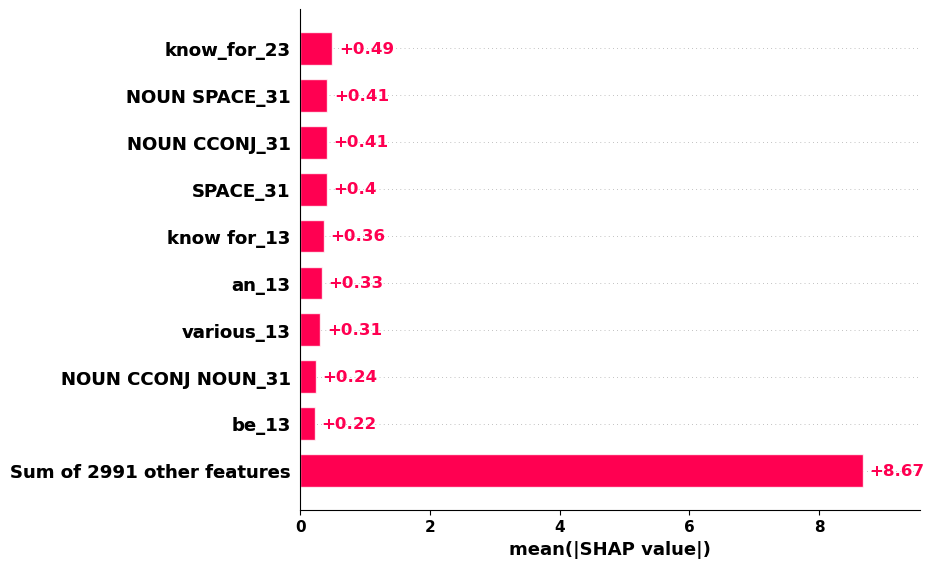

In [14]:
shap.plots.bar(shap_values)

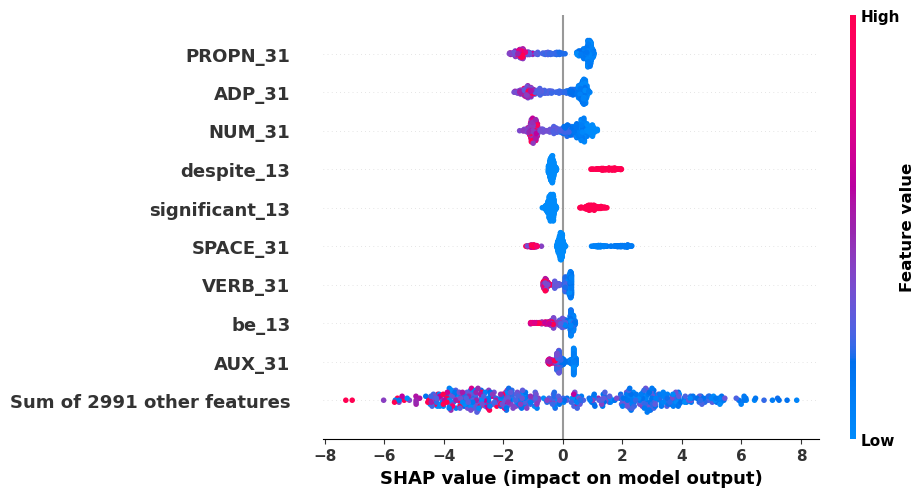

In [16]:
shap.plots.beeswarm(shap_values)